1. input svg
2. deconstruct svg into layers
3. prepare each layer (masking), some layers have interaction
4. parse through terrain algorithm to get heightmap

In [73]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import get_city_coordinates, get_island_coordinates
from image_ops import flood_image

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

In [74]:
import ipywidgets as widgets
from IPython.display import display
import glob
realm_selection = widgets.Dropdown(
    options=glob.glob("../svgs/*.svg"),
    description='svg:',
    disabled=False,
)
display(realm_selection)

Dropdown(description='svg:', options=('../svgs/6316.svg', '../svgs/4425.svg', '../svgs/7065.svg', '../svgs/133…

In [84]:
realm_path = realm_selection.value
realm_number = realm_path.split("/")[:-4]

In [85]:
config = OmegaConf.load("../pipeline/config.yaml")
# this is how you can access the config
# we will use padding more often
p = config.svg.padding
config

{'svg': {'scaling': 2.0, 'padding': 50, 'city_alpha': 1.25, 'island_alpha': 1.575}, 'closing': {'min_n_points': 3, 'rng': 448, 'magnet': 10}, 'pipeline': {'use_rivers': True, 'use_cities': True, 'use_islands': True}, 'terrain': {'mountains': 10}, 'export': {'size': 512}}

In [86]:
extractor = SVGExtractor(realm_path, scale=config.svg.scaling)

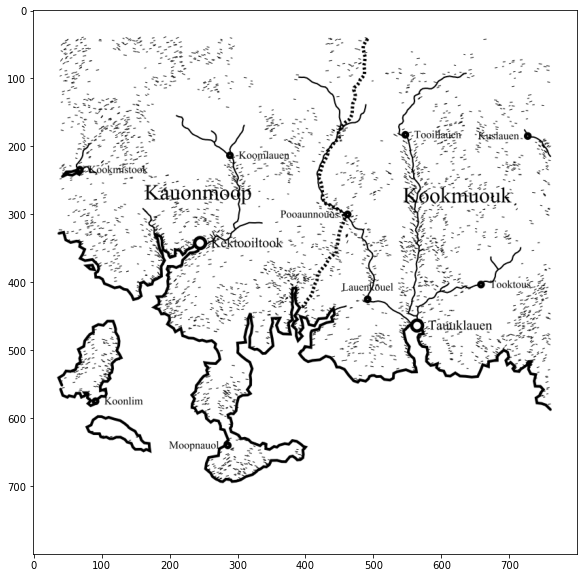

In [87]:
extractor.show()

In [88]:
drawing = extractor.coast()
island_centers = get_island_coordinates(
    drawing,
    padding=p,
    scaling=1.6
)
# also get the coast image, we will use this later
coast_img = extractor.get_img()

In [89]:
drawing = extractor.cities()
city_centers = get_city_coordinates(
    drawing,
    padding=p,
    scaling=config.svg.city_alpha
)

In [90]:
# some small checks
for city_center in city_centers:
    if 0 <= city_center[0] < drawing.width and 0 <= city_center[1] < drawing.height:
        pass
    else:
        print(f"out of bounds city center!: {city_center}")

    
for island_center in island_centers:
    if 0 <= island_center[0] < drawing.width and 0 <= island_center[1] < drawing.height:
        pass
    else:
        print(f"out of bounds island center!: {island_center}")

In [91]:
# we will now use islands centers and cities to fill land.
# surely we will miss some parts, but we can fix that later

flooded_image = flood_image(
    coast_img,
    [
        *city_centers,
        *island_centers
    ], p)

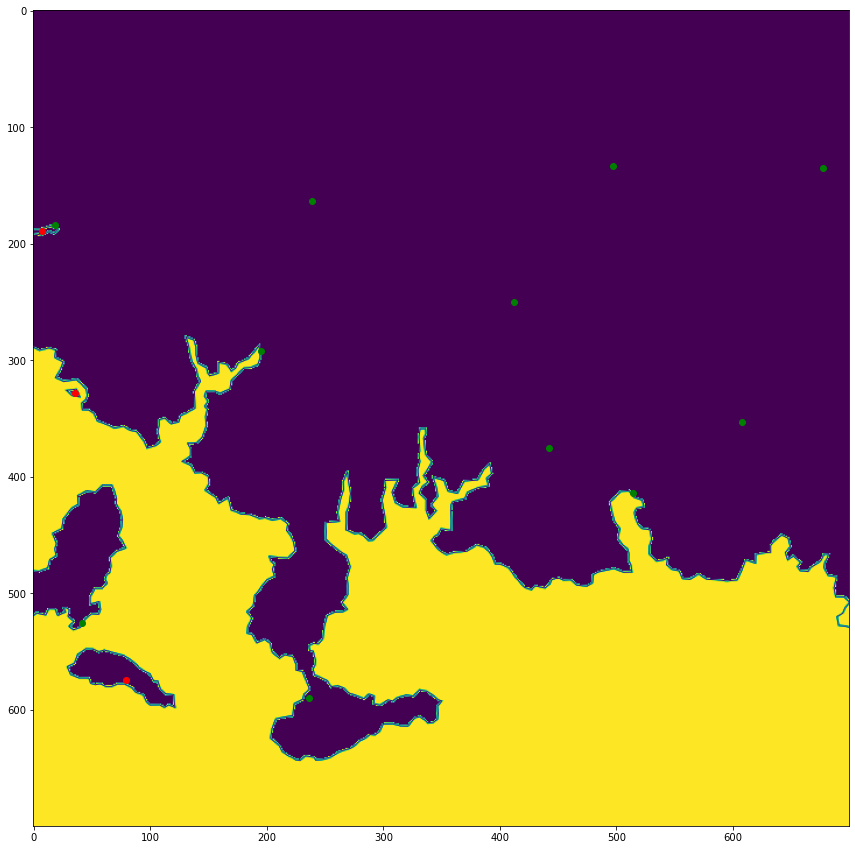

In [92]:
# check the intermediate result
plt.figure(figsize=(15,15))
for center in city_centers:
    plt.plot(center[1], center[0], 'go')  # seed point
for center in island_centers:
    plt.plot(center[1], center[0], 'ro')  # seed point
plt.imshow(flooded_image)

In [93]:
# go throught he lines of each path:
# aggregate surrounding information
# if the average is around .5, it means one half is filled
# if the average is close to 0, it needs filling

drawing = extractor.coast()

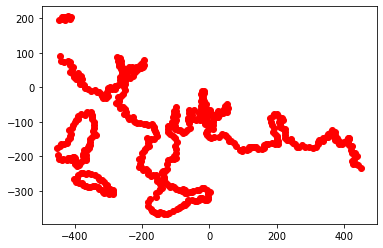

In [94]:
for path_group in drawing.contents[0].contents:
    path = path_group.contents[0]
    for i in range(0, len(path.points)-2, 2):
        plt.plot(path.points[i], -path.points[i+1], 'ro')  # seed point

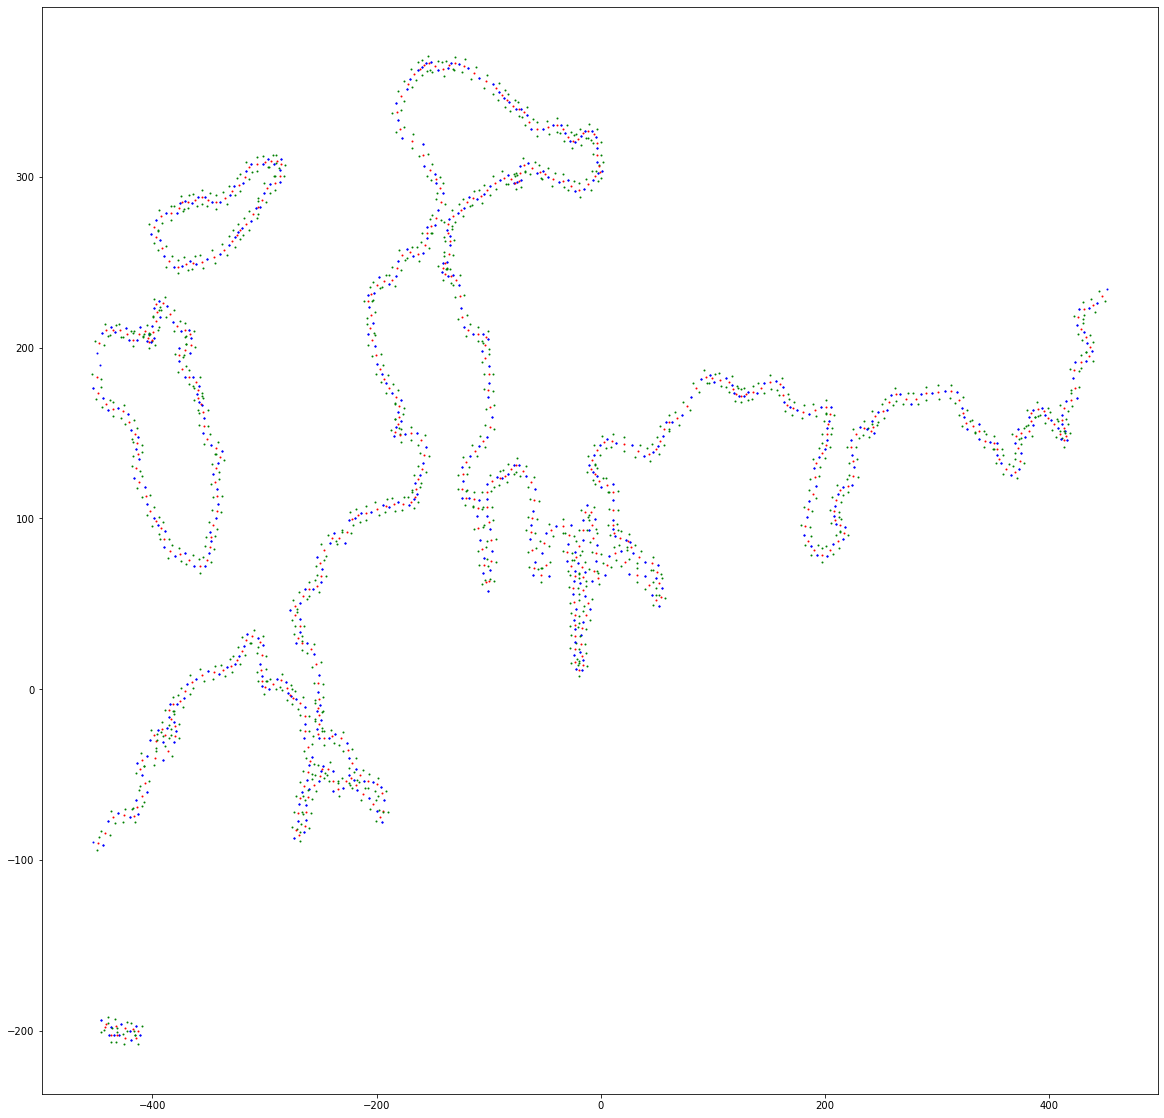

In [95]:
plt.figure(figsize=(20,20))

DIS_FROM_CENTER = 4

for path_group in drawing.contents[0].contents:
    path = path_group.contents[0]
    for i in range(0, len(path.points)-2, 2):
        a = np.array([path.points[i], path.points[i+1]])
        b = np.array([path.points[i+2], path.points[i+3]])
        
        if a[1] == b[1]:
            print("y aligned")
        elif a[0] == b[0]:
            print("x aligned")
        else:
            m_inv = -(b[0]-a[0])/(b[1]-a[1])
            center = (a+b)/2
            c = center[1] - m_inv*center[0]
            other_1 = np.array([center[0]+1, m_inv*(center[0]+1)+c])
            other_2 = np.array([center[0]-1, m_inv*(center[0]-1)+c])
            dis = np.linalg.norm(other_1-center)
            other_1 /= dis
            other_2 /= dis
            other_1 = np.array([center[0]+DIS_FROM_CENTER/dis, m_inv*(center[0]+DIS_FROM_CENTER/dis)+c])
            other_2 = np.array([center[0]-DIS_FROM_CENTER/dis, m_inv*(center[0]-DIS_FROM_CENTER/dis)+c])
            plt.plot(a[0], a[1], 'bo', markersize=1)
            plt.plot(b[0], b[1], 'bo', markersize=1)
            plt.plot(center[0], center[1], 'ro', markersize=1)
            plt.plot(other_1[0], other_1[1], 'go', markersize=1)
            plt.plot(other_2[0], other_2[1], 'go', markersize=1)

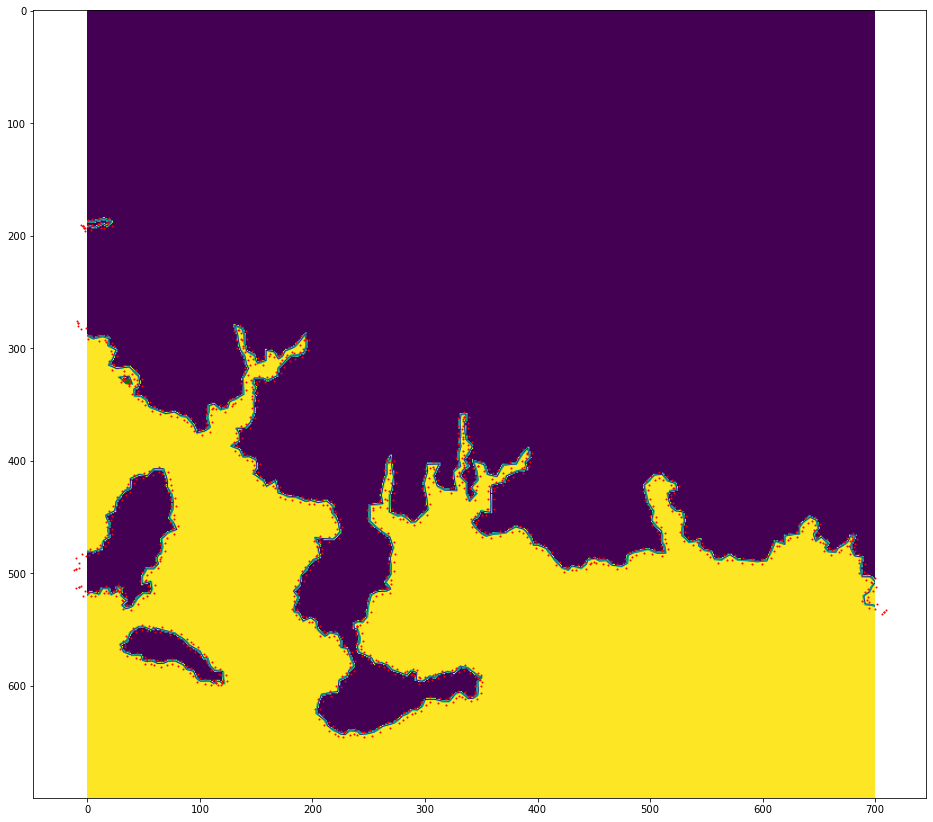

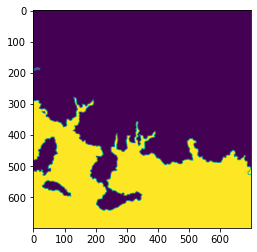

In [98]:
from skimage.segmentation import flood, flood_fill

def get_orthogonal_samples(path, drawing_size, padding=45, scaling=1.6):
    """This function takes a path and iterates on its points.
    It draws a line between two subsequent points and finds the line that
    is orthogonal and goes through the center. It then returns two points
    on either side of the original line.
            o1
            |
    a ===== c ===== b
            |
            o2
    """
    DIS_FROM_CENTER = 3
    
    samples = []
    for i in range(0, len(path.points)-2, 2):
        a = np.array([path.points[i], path.points[i+1]])
        b = np.array([path.points[i+2], path.points[i+3]])
        
        if a[1] == b[1]:
            print("y aligned")
        elif a[0] == b[0]:
            print("x aligned")
        else:
            m_inv = -(b[0]-a[0])/(b[1]-a[1])
            center = (a+b)/2
            c = center[1] - m_inv*center[0]
            other_1 = np.array([center[0]+1, m_inv*(center[0]+1)+c])
            other_2 = np.array([center[0]-1, m_inv*(center[0]-1)+c])
            dis = np.linalg.norm(other_1-center)
            other_1 = np.array([center[0]+DIS_FROM_CENTER/dis, m_inv*(center[0]+DIS_FROM_CENTER/dis)+c])
            other_2 = np.array([center[0]-DIS_FROM_CENTER/dis, m_inv*(center[0]-DIS_FROM_CENTER/dis)+c])
            samples.append(other_1/scaling+drawing_size//2-padding)
            samples.append(other_2/scaling+drawing_size//2-padding)
    return samples
         
def refine_mask(incomplete_mask, coast_drawing):
    """Requires an incomplete mask and a coast drawing."""
    plt.figure(figsize=(16,16))
    new_img = flooded_image.copy()
    plt.imshow(new_img)
    for path_group in drawing.contents[0].contents:
        path = path_group.contents[0]
        samples = get_orthogonal_samples(path, drawing.height, padding=p, scaling=1.25)
        samples = np.vstack(samples)
        
        aggr = []
        for sample in samples:
            x, y = int(sample[0]), int(sample[1])
            if 0 <= x < flooded_image.shape[0] and 0 <= y < flooded_image.shape[1]:
                aggr.append(flooded_image[y,x])
        if len(aggr) > 3:
            c_beg = (samples[0]+samples[1])/2
            c_end = (samples[-2]+samples[-1])/2
            # make the first and last nodes count more for missing nodes in between
            avg = sum(aggr)/len(aggr)
            samples = np.vstack([samples, c_beg, c_beg, c_end, c_end])
            # if more samples on both sides of the line are 0, then we have an empty shape!
            if avg > 150:
                # the first moment of the samples should more or less match that of the actual points
                center = np.mean(samples, axis=0)
                plt.plot(center[0], center[1], 'go', markersize=5)
                new_img = flood_fill(new_img, (int(center[1]), int(center[0])), 0)
            
        plt.plot(samples[:,0], samples[:,1], 'ro', markersize=1)
    return new_img
refined_image = refine_mask(flooded_image, drawing)

plt.show()
plt.imshow(refined_image)

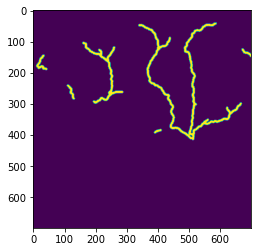

In [99]:
extractor.rivers()
rivers = np.asarray(extractor.get_img())[p:-p,p:-p,0] # rivers is now [0,255]

rivers = skimage.filters.gaussian(rivers, sigma=1.5) # rivers is now [0,1]
rivers = (rivers < 0.99)*255

plt.imshow(rivers)

In [100]:
np.logical_or(flooded_image, rivers)-1

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

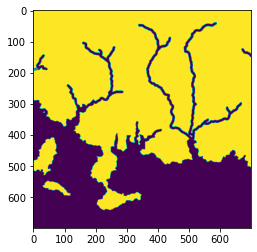

In [101]:
plt.imshow((np.logical_or(flooded_image, rivers)-1)*-255)

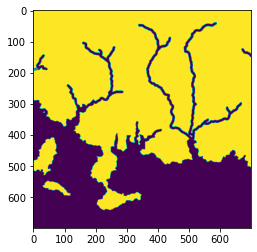

In [102]:
final_mask = (np.logical_or(flooded_image, rivers)-1)*-255

# bg = np.zeros((final_mask.shape[0]+water_padding*2, final_mask.shape[1]+water_padding*2))
# bg[water_padding:-water_padding,water_padding:-water_padding] = final_mask
# final_mask=bg

# sanity check to only have 0 and 255
assert np.unique(final_mask).shape[0] == 2
plt.imshow(final_mask)

In [106]:
anti_final_mask = final_mask*-1+255

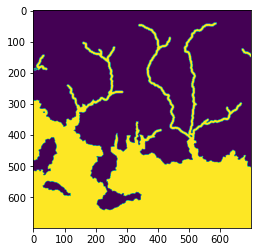

In [109]:
plt.imshow(anti_final_mask)

# terrain generation

In [110]:
padding = 20
f2 = np.zeros((final_mask.shape[0]+2*padding, final_mask.shape[1]+2*padding))
f2[padding:-padding,padding:-padding] = final_mask
final_mask=f2

In [111]:
#   * directional_interta: indicates how straight the rivers are
#       (0 = no directional inertia, 1 = total directional inertia).
#   * default_water_level: How much water is assigned by default to each point
#   * evaporation_rate: How much water is evaporated as it traverses from along
#       each river edge.

# this is still most copy pasta
dim = final_mask.shape[0]
shape = (dim,) * 2
disc_radius = 4.
max_delta = 0.1
river_downcutting_constant = 1.3
directional_inertia = 0.6
default_water_level = 1.0
evaporation_rate = 0.5

# coastal
DROPOFF = 44.0 # high: very small slope towards sea, low: abrup change to sea

# mountain
MOUNTAIN_SIGMA = 1.0

# lakes
ALPHA = 0.1

print ('Generating...')

print('  ...initial terrain shape')
land_mask = remove_lakes(
  (util.fbm(shape, -2, lower=2.0) + bump(shape, 0.2 * dim) - ALPHA) > 0)
land_mask = final_mask > 0
coastal_dropoff = np.tanh(util.dist_to_mask(land_mask) / DROPOFF) * land_mask
mountain_shapes = util.fbm(shape, -2, lower=2.0, upper=np.inf)
initial_height = ( 
  (util.gaussian_blur(np.maximum(mountain_shapes - 0.4, 0.0), sigma=MOUNTAIN_SIGMA) 
    + 0.1) * coastal_dropoff)
deltas = util.normalize(np.abs(util.gaussian_gradient(initial_height))) 

print('  ...sampling points')
points = util.poisson_disc_sampling(shape, disc_radius)
coords = np.floor(points).astype(int)

print('  ...delaunay triangulation')
tri = sp.spatial.Delaunay(points)
(indices, indptr) = tri.vertex_neighbor_vertices
neighbors = [indptr[indices[k]:indices[k + 1]] for k in range(len(points))]
points_land = land_mask[coords[:, 0], coords[:, 1]]
points_deltas = deltas[coords[:, 0], coords[:, 1]]

print('  ...initial height map')
points_height = compute_height(points, neighbors, points_deltas)

print('  ...river network')
(upstream, downstream, volume) = compute_river_network(
  points, neighbors, points_height, points_land,
  directional_inertia, default_water_level, evaporation_rate)

print('  ...final terrain height')
new_height = compute_final_height(
  points, neighbors, points_deltas, volume, upstream, 
  max_delta, river_downcutting_constant)
terrain_height = render_triangulation(shape, tri, new_height)



Generating...
  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


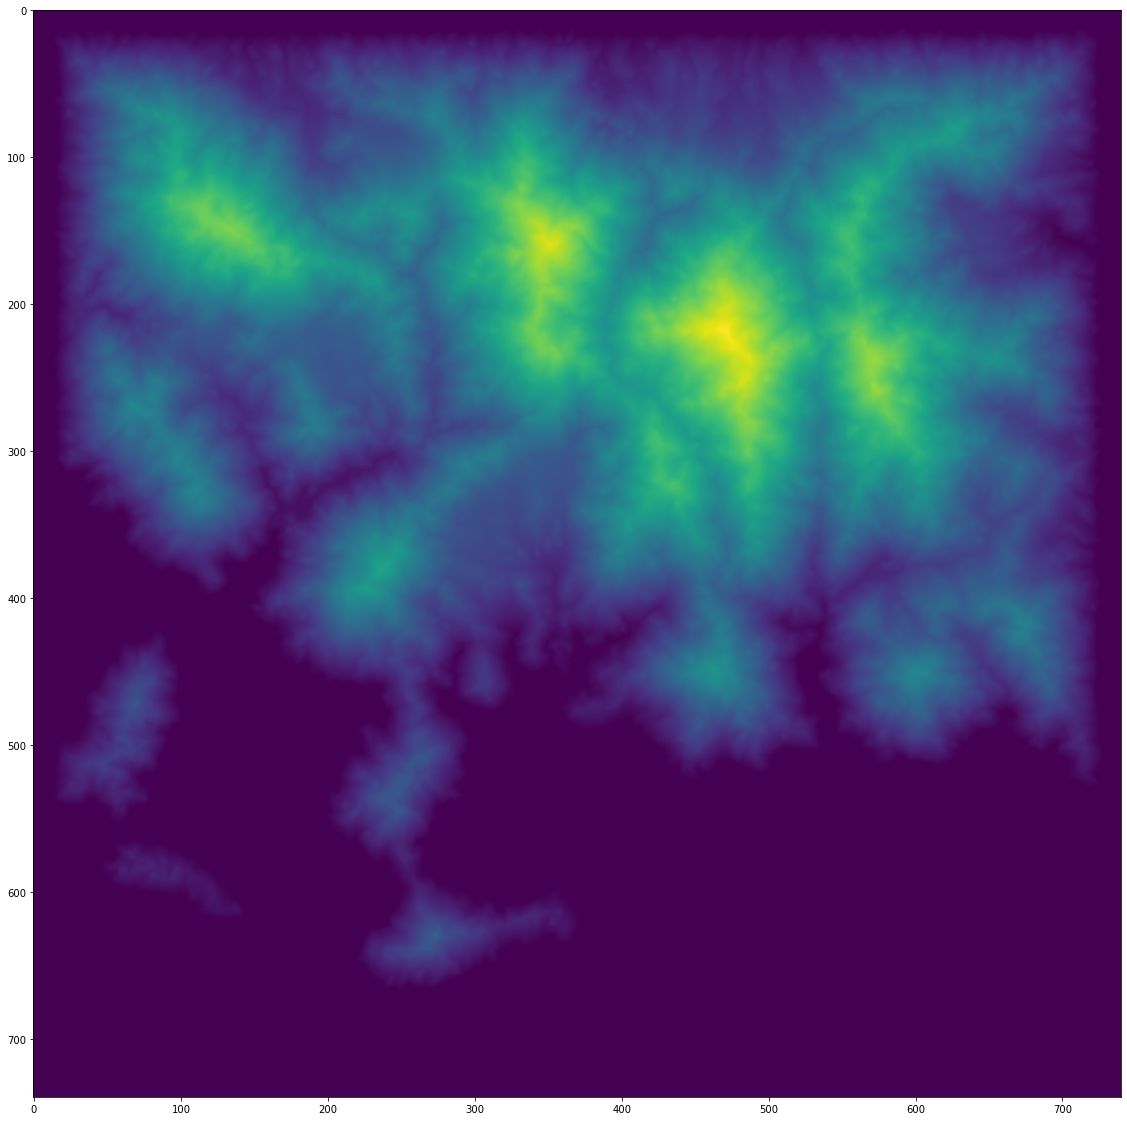

In [112]:
plt.figure(figsize=(20,20))
plt.imshow(terrain_height)

# combine final_mask and anti_final_mask

In [117]:
# this is still most copy pasta
dim = anti_final_mask.shape[0]
shape = (dim,) * 2
disc_radius = 4.
max_delta = 0.05
river_downcutting_constant = 1.3
directional_inertia = 0.1
default_water_level = 1.0
evaporation_rate = 0.1

# coastal
DROPOFF = 50.0 # high: very small slope towards sea, low: abrup change to sea

# mountain
MOUNTAIN_SIGMA = 1.0

# lakes
ALPHA = 0.1

print ('Generating...')

print('  ...initial terrain shape')
land_mask = remove_lakes(
  (util.fbm(shape, -2, lower=2.0) + bump(shape, 0.2 * dim) - ALPHA) > 0)
land_mask = anti_final_mask > 0
coastal_dropoff = np.tanh(util.dist_to_mask(land_mask) / DROPOFF) * land_mask
mountain_shapes = util.fbm(shape, -2, lower=2.0, upper=np.inf)
initial_height = ( 
  (util.gaussian_blur(np.maximum(mountain_shapes - 0.4, 0.0), sigma=MOUNTAIN_SIGMA) 
    + 0.1) * coastal_dropoff)
deltas = util.normalize(np.abs(util.gaussian_gradient(initial_height))) 

print('  ...sampling points')
points = util.poisson_disc_sampling(shape, disc_radius)
coords = np.floor(points).astype(int)

print('  ...delaunay triangulation')
tri = sp.spatial.Delaunay(points)
(indices, indptr) = tri.vertex_neighbor_vertices
neighbors = [indptr[indices[k]:indices[k + 1]] for k in range(len(points))]
points_land = land_mask[coords[:, 0], coords[:, 1]]
points_deltas = deltas[coords[:, 0], coords[:, 1]]

print('  ...initial height map')
points_height = compute_height(points, neighbors, points_deltas)

print('  ...river network')
(upstream, downstream, volume) = compute_river_network(
  points, neighbors, points_height, points_land,
  directional_inertia, default_water_level, evaporation_rate)

print('  ...final terrain height')
new_height = compute_final_height(
  points, neighbors, points_deltas, volume, upstream, 
  max_delta, river_downcutting_constant)
water_depth = render_triangulation(shape, tri, new_height)

Generating...
  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


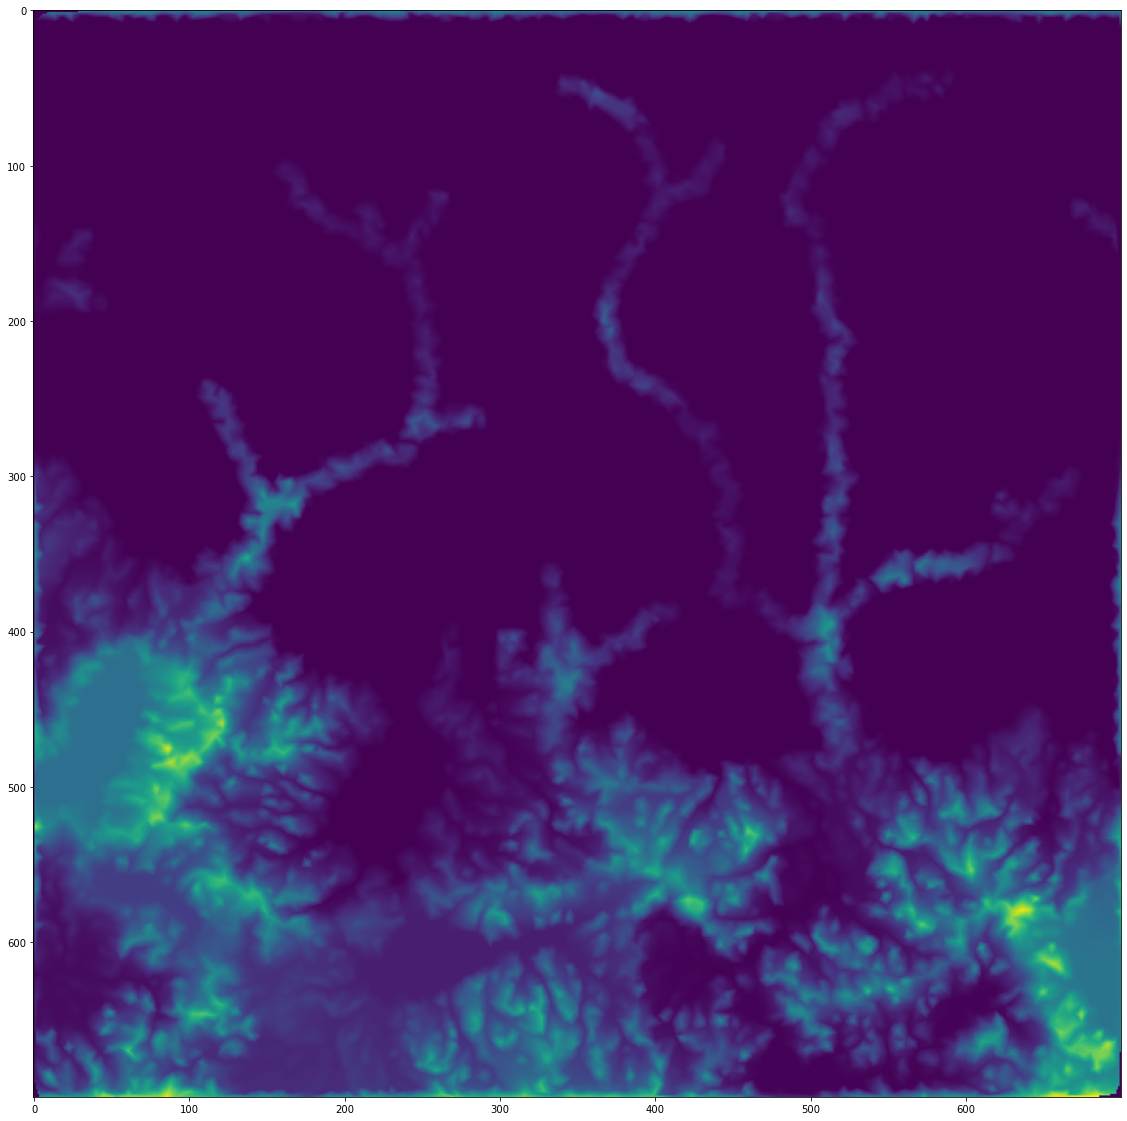

In [118]:
plt.figure(figsize=(20,20))
plt.imshow(water_depth)

In [126]:
m1 = final_mask[padding:-padding, padding:-padding]
_m1 = m1 < 255
m2 = terrain_height[padding:-padding, padding:-padding]
m3 = water_depth

In [133]:
combined = m2 - 0.2*_m1*m3

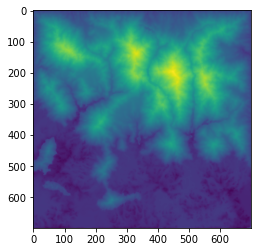

In [134]:
plt.imshow(combined)

In [139]:
combined = (combined-combined.min())/(combined.max()-combined.min())
print(combined.min(), combined.max())

0.0 1.0


# export

In [141]:
qmap = (combined*255).astype(np.uint8)
qimg = PIL.Image.fromarray(qmap).convert('L')
qimg = qimg.resize((config.export.size, config.export.size))
qimg.save(f"../output/height_{realm_number}.png")

# coloring

<BarContainer object of 50 artists>

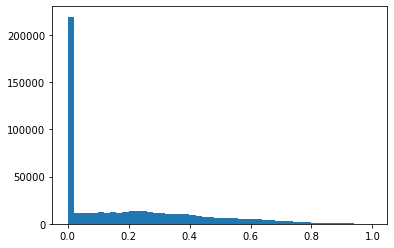

In [142]:
plt.hist(terrain_height.flatten(), bins=50)[2]

In [185]:
def get_color(height):
    if height > .8:
        return np.array([230, 230, 230]) #white
    if height > .4:
        return np.array([158, 158, 158]) #grey
    if height > .1:
        return np.array([140, 174, 106]) #green
    if height > .05:
        return np.array([140, 150, 106]) #green
    if height > .01:
        return np.array([100,  76,  76]) #brown
    return np.array([  0,   0, 255]) #blue

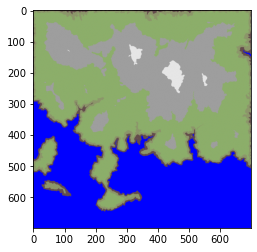

In [186]:
colorqmap = np.zeros((*combined.shape, 3))
sea_level = np.logical_or(flooded_image, rivers)*0.1
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        colorqmap[x,y,:] = get_color(terrain_height[x+padding,y+padding])
plt.imshow(colorqmap/255)

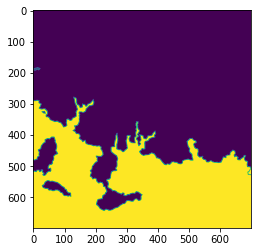

In [187]:
water_level_1 = flooded_image/255*0.05
plt.imshow(water_level_1)

In [192]:
# extractor.rivers()
rivers = np.asarray(extractor.get_img())[p:-p,p:-p,0] # rivers is now [0,255]
water_level_2 = (rivers<255)*0.05
water_level_2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

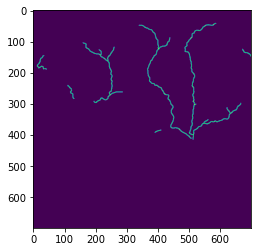

In [193]:
plt.imshow(water_level_2)

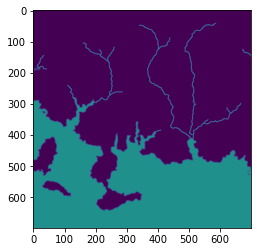

In [194]:
plt.imshow(water_level_1 + water_level_2)

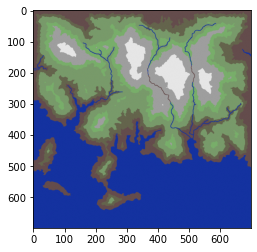

In [208]:
def get_color(height):
    if height > .7:
        return np.array([230, 230, 230]) #white
    if height > .5:
        return np.array([158, 158, 158]) #grey
    if height > .4:
        return np.array([120, 174, 106]) #green
    if height > .23:
        return np.array([120, 154, 106]) #green
    if height > .15:
        return np.array([100,  100,  76]) #brown
    if height > .01:
        return np.array([100,  76,  76]) #brown
    return np.array([  20,   50, 160]) #blue

colorqmap = np.zeros((*combined.shape, 3))
sea_level = water_level_1+water_level_2
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        colorqmap[x,y,:] = get_color(terrain_height[x+padding,y+padding]-10*sea_level[x,y])
plt.imshow(colorqmap/255)

In [202]:
colorqmap_export = colorqmap.astype(np.uint8)
colorqmap_export = PIL.Image.fromarray(colorqmap_export)
colorqmap_export = colorqmap_export.resize((config.export.size, config.export.size))
colorqmap_export.save(f"../output/color_{realm_number}.png")